<a href="https://colab.research.google.com/github/Mahmood-Anaam/llms/blob/main/notebooks/LLMS_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## New Section

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('stabilityai/ar-stablelm-2-chat',trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    'stabilityai/ar-stablelm-2-chat',
    device_map="auto",
    trust_remote_code=True
)

prompt = [{'role': 'user', 'content': 'ماهو إعراب الجملة: ذهبت إلى السوق'}]
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    return_tensors='pt'
)

tokens = model.generate(
    inputs.to(model.device),
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True
)
output = tokenizer.decode(tokens[:, inputs.shape[-1]:][0], skip_special_tokens=False)

print(output)

tokenizer_config.json:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

configuration_stablelm_epoch.py:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/stabilityai/ar-stablelm-2-chat:
- configuration_stablelm_epoch.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_stablelm_epoch.py:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/stabilityai/ar-stablelm-2-chat:
- modeling_stablelm_epoch.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


​ذهبْتُ: فعل ماض مبني على السكون، والتاء ضمير متصل في محل رفع فاعل. إلى: حرف جر مبني على السكون. السوق: اسم مجرور وعلامة جره الكسرة.<|im_end|>



In [ ]:
# الأوصاف الناتجة مسبقًا (6 أوصاف)
captions = [
    "هناك صندوق إطفاء أحمر على جانب الطريق.",
    "صندوق الإطفاء الأحمر مثبت بجانب الطريق.",
    "صندوق الإطفاء الأحمر على زاوية الشارع.",
    "يوجد صندوق إطفاء أحمر بجوار المبنى.",
    "صندوق الإطفاء يبدو واضحًا بجانب الطريق.",
    "صندوق الإطفاء الأحمر يقع بالقرب من الرصيف."
]

# نص السؤال
question = "ما نوع المركبة التي تستخدم هذا الشيء؟"

# تكوين النص المدخل (Prompt)
context = " ".join(captions)  # دمج الأوصاف معًا
sysprompt = f"أجب بشكل مختصر عن السؤال من السياق التالي: السياق: {context}. السؤال: {question}"

# عرض البرمبت
print("sysprompt:")
print(sysprompt)

sysprompt:
أجب بشكل مختصر عن السؤال من السياق التالي: السياق: هناك صندوق إطفاء أحمر على جانب الطريق. صندوق الإطفاء الأحمر مثبت بجانب الطريق. صندوق الإطفاء الأحمر على زاوية الشارع. يوجد صندوق إطفاء أحمر بجوار المبنى. صندوق الإطفاء يبدو واضحًا بجانب الطريق. صندوق الإطفاء الأحمر يقع بالقرب من الرصيف.. السؤال: ما نوع المركبة التي تستخدم هذا الشيء؟


In [ ]:


prompt = [{'role': 'user', 'content': sysprompt}]
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    return_tensors='pt'
)

tokens = model.generate(
    inputs.to(model.device),
    max_new_tokens=100,
    temperature=0.0,
    do_sample=True
)
output = tokenizer.decode(tokens[:, inputs.shape[-1]:][0], skip_special_tokens=False)

print(output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


المركبة التي تستخدم صندوق الإطفاء هي سيارة.<|im_end|>
يعتبر صندوق الإطفاء جزءًا مهمًا من السلامة على الطريق ويجب دائمًا أن يكون في مكان واضح لتس


In [ ]:
output

'المركبة التي تستخدم صندوق الإطفاء هي سيارة.<|im_end|>\nيعتبر صندوق الإطفاء جزءًا مهمًا من السلامة على الطريق ويجب دائمًا أن يكون في مكان واضح لتس'

---

In [ ]:
!pip install arabert --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2TokenizerFast, pipeline
#for base and medium
from transformers import GPT2LMHeadModel
#for large and mega
# pip install arabert
from arabert.aragpt2.grover.modeling_gpt2 import GPT2LMHeadModel

from arabert.preprocess import ArabertPreprocessor

MODEL_NAME='aubmindlab/aragpt2-base'
arabert_prep = ArabertPreprocessor(model_name=MODEL_NAME)


model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
generation_pipeline = pipeline("text-generation",model=model,tokenizer=tokenizer)

#feel free to try different decoding settings

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

GPT2LMHeadModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at aubmindlab/aragpt2-base were not used when initializing GPT2LMHeadModel: ['ln_f.bias', 'ln_f.weight']
- This IS expected if 

vocab.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
text=sysprompt
text_clean = arabert_prep.preprocess(text)
text_clean

'أجب بشكل مختصر عن السؤال من السياق التالي : السياق : هناك صندوق إطفاء أحمر على جانب الطريق . صندوق الإطفاء الأحمر مثبت بجانب الطريق . صندوق الإطفاء الأحمر على زاوية الشارع . يوجد صندوق إطفاء أحمر بجوار المبنى . صندوق الإطفاء يبدو واضحا بجانب الطريق . صندوق الإطفاء الأحمر يقع بالقرب من الرصيف . . السؤال : ما نوع المركبة التي تستخدم هذا الشيء ؟'

In [ ]:
output = generation_pipeline(text_clean,
    pad_token_id=tokenizer.eos_token_id,
    num_beams=10,
    max_length=100,
    truncation=True,
    top_p=0.0,
    repetition_penalty = 3.0,
    no_repeat_ngram_size = 3)[0]['generated_text']

In [ ]:
output

'أجب بشكل مختصر عن السؤال من السياق التالي : السياق : هناك صندوق إطفاء أحمر على جانب الطريق . صندوق الإطفاء الأحمر مثبت بجانب الطريق . صندوق الإطفاء الأحمر على زاوية الشارع . يوجد صندوق إطفاء أحمر بجوار المبنى . صندوق الإطفاء يبدو واضحا بجانب الطريق . صندوق الإطفاء الأحمر يقع بالقرب من الرصيف . . السؤال : ما نوع المركبة التي تستخدم هذا الشيء ؟ و إلى الى " كما في قد ،لو “ع فى ( ان # ” وجانه ولا ام لا وهولا\'حتى هو وق أوالى وش أموج'



---



# LLMs Demo

## Import all libraries

In [2]:
!pip install datasets --q

In [3]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import requests
import pandas as pd
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset
import datasets
import os


## Configuration

In [73]:
import textwrap

PROMPTS = {

    "default": textwrap.dedent("""
    Based on the following image captions, answer the question:
    {captions}
    Question: {question}
    Answer:
    """).strip(),

    "detailed": textwrap.dedent("""
    The image contains objects described below:
    {captions}
    Can you answer the following question based on these descriptions?
    Question: {question}
    Answer:
    """).strip(),

    "simple": textwrap.dedent("""
    {captions}
    Q: {question}
    A:
    """).strip(),

}

print(PROMPTS["default"])

Based on the following image captions, answer the question:
{captions}
Question: {question}
Answer:


In [74]:
import torch

class Config:

  VDS_PATH = "MahmoodAnaam/OKVQA-Encoder-Violet-Captions"
  BDS_PATH = "MahmoodAnaam/OKVQA-VinVL-BiT-Captions"
  SPLIT = "validation"
  LANGUAGE = "ar"
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

  BATCH_SIZE = 20
  CAPTIONS = ["bit","violet"]
  PROMPT_TEMPLATE = PROMPTS["default"]






## DataSets

In [12]:
import torch

class OKVQADataset(torch.utils.data.Dataset):
    def __init__(self, BDS, VDS, language="ar"):
        self.BDS = BDS
        self.VDS = VDS
        self.language = language

    def __len__(self):
        return len(self.BDS)

    def __getitem__(self, idx):
        example = {
            "metadata": self.BDS[idx]["metadata"],
            "image": self.BDS[idx]["image"],
            "question": self.BDS[idx]["question"].get(self.language),
            "answers": self.BDS[idx]["answers"].get(self.language),
            "bit": {
                "captions": [cap.get("caption") for cap in self.BDS[idx]['captions']],
                "image_feats": self.BDS[idx]['features']['img_feats'],
                'od_labels': self.BDS[idx]['features']['od_labels']
            },
            "violet": {
              "captions": [cap.get("caption") for cap in self.VDS[idx]['captions']],
              "image_feats": self.VDS[idx]['features']
          },

        }
        return example

In [6]:
VDS= load_dataset(Config.VDS_PATH,split=Config.SPLIT)
BDS = load_dataset(Config.BDS_PATH,split=Config.SPLIT)

README.md:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/5046 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

validation-00000-of-00005.parquet:   0%|          | 0.00/298M [00:00<?, ?B/s]

validation-00001-of-00005.parquet:   0%|          | 0.00/306M [00:00<?, ?B/s]

validation-00002-of-00005.parquet:   0%|          | 0.00/302M [00:00<?, ?B/s]

validation-00003-of-00005.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

validation-00004-of-00005.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/5046 [00:00<?, ? examples/s]

In [8]:
BDS,VDS

(Dataset({
     features: ['metadata', 'image', 'question', 'answers', 'features', 'captions'],
     num_rows: 5046
 }),
 Dataset({
     features: ['metadata', 'image', 'question', 'answers', 'features', 'captions'],
     num_rows: 5046
 }))

In [29]:
dataset = OKVQADataset(BDS,VDS,language=Config.LANGUAGE)
print(dataset[0].keys())
print(dataset[0]['metadata'].keys())
print(dataset[0]['bit'].keys())
print(dataset[0]['violet'].keys())

dict_keys(['metadata', 'image', 'question', 'answers', 'bit', 'violet'])
dict_keys(['image_id', 'question_id', 'question_type', 'answer_type', 'confidence'])
dict_keys(['captions', 'image_feats', 'od_labels'])
dict_keys(['captions', 'image_feats'])


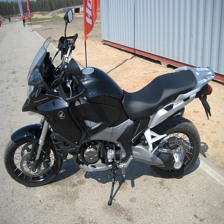

In [14]:
dataset[0]['image'].resize((224,224))

In [15]:
print("Question: ",dataset[0]['question'])
print("Answers: ",dataset[0]['answers'])
print("Bit captions: ",dataset[0]['bit']['captions'])
print("Violet captions: ",dataset[0]['violet']['captions'])

Question:  في أي رياضة يمكنك استخدام هذا؟
Answers:  ['سباق', 'سباق', 'سباق', 'سباق', 'سباق', 'سباق', 'موتوكروس', 'موتوكروس', 'يركب', 'يركب']
Bit captions:  ['امراة ترتدي بدلة سوداء وبيضاء تركب دراجتها في الشارع', 'امراة ترتدي بدلة سوداء وبيضاء تركب دراجتها في موقف للسيارات', 'امراة ترتدي بدلة سوداء وبيضاء تركب دراجة ثلاثية العجلات']
Violet captions:  [' دراجة نارية سوداء وفضية متوقفة في موقف للسيارات', ' دراجة نارية سوداء وفضية متوقفة في الكثير', ' دراجة نارية بيضاء وسوداء متوقفة في موقف للسيارات']




---



In [79]:
import torch

class OKVQADataLoader:
    def __init__(self, dataset, config):
        """
        Initializes the data loader for the OKVQA dataset.

        Args:
            dataset (torch.utils.data.Dataset): The dataset object.
            config (Config): The configuration object containing batch size and prompt formatting rules.
        """
        self.dataset = dataset
        self.batch_size = config.BATCH_SIZE
        self.device = config.DEVICE
        self.prompt_template = config.PROMPT_TEMPLATE  # General prompt template from Config
        self.captions_keys = config.CAPTIONS

    def create_prompt(self, question, captions):
        """
        Generates a prompt based on the provided question and captions using the template from Config.

        Args:
            question (str): The question text.
            captions (dict): A dictionary containing captions for different models.

        Returns:
            str: The formatted prompt.
        """
        # Filter and format captions based on the specified keys in Config
        selected_captions = []
        for key in self.captions_keys:
            if key in captions:
                selected_captions.extend(captions[key])

        formatted_captions = "\n".join(selected_captions)
        return self.prompt_template.format(question=question, captions=formatted_captions)

    def collate_fn(self, batch):
        """
        Custom collate function for preparing the batch data.

        Args:
            batch (list): A list of samples from the dataset.

        Returns:
            dict: A dictionary containing batched prompts, answers, images, and metadata.
        """
        prompts = []
        answers = []
        images = []
        metadata = []

        for item in batch:
            prompt = self.create_prompt(item["question"], {
                "bit": item["bit"]["captions"],
                "violet": item["violet"]["captions"]
            })
            prompts.append(prompt)
            answers.append(item["answers"])
            images.append(item["image"])
            metadata.append(item["metadata"])

        return {
            "prompts": prompts,
            "answers": answers,
            "images": images,
            "metadata": metadata
        }

    def get_dataloader(self):
        """
        Returns a DataLoader object for the dataset.

        Returns:
            torch.utils.data.DataLoader: The DataLoader instance.
        """
        return torch.utils.data.DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [93]:
dataloader = OKVQADataLoader(dataset, Config).get_dataloader()

In [113]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['prompts', 'answers', 'images', 'metadata'])


In [114]:
print("\n\n".join(batch['prompts'][:3]))

Based on the following image captions, answer the question:
امراة ترتدي بدلة سوداء وبيضاء تركب دراجتها في الشارع
امراة ترتدي بدلة سوداء وبيضاء تركب دراجتها في موقف للسيارات
امراة ترتدي بدلة سوداء وبيضاء تركب دراجة ثلاثية العجلات
 دراجة نارية سوداء وفضية متوقفة في موقف للسيارات
 دراجة نارية سوداء وفضية متوقفة في الكثير
 دراجة نارية بيضاء وسوداء متوقفة في موقف للسيارات
Question: في أي رياضة يمكنك استخدام هذا؟
Answer:

Based on the following image captions, answer the question:
امراة في صالون تجميل تنظر الى شيء ما
امراة تجلس على طاولة في مطعم
امراة تجلس في صالون تجميل في الهواء الطلق
 حمام مع حوض غسيل ومرحاض
 حمام مع حوض غسيل ومرايا
 حمام مع حوض غسيل ومرايا كبيرة
Question: اذكر نوع النبات هذا؟
Answer:

Based on the following image captions, answer the question:
شخصان يجلسان في صف من الكتب
شخصان يجلسان في صفوف من الكتب
ثلاثة اشخاص يجلسون في صفوف من الكتب
 مجموعة من الناس يجلسون معاً
 رجل يحمل دبّة دمية في حضنه
 رجل يحمل دبّة دمية بينما يجلس على مقعد
Question: أي لعبة هذه؟
Answer:


In [111]:
batch['answers'][:5]

[['سباق',
  'سباق',
  'سباق',
  'سباق',
  'سباق',
  'سباق',
  'موتوكروس',
  'موتوكروس',
  'يركب',
  'يركب'],
 ['كرمة',
  'كرمة',
  'كرمة',
  'كرمة',
  'تسلق',
  'تسلق',
  'تبدو وكأنها نوع من اللبلاب',
  'تبدو وكأنها نوع من اللبلاب',
  'اللبخ',
  'اللبخ'],
 ['حيوان محشو',
  'حيوان محشو',
  'حيوان محشو',
  'حيوان محشو',
  'حيوان محشو',
  'حيوان محشو',
  'دمية دب',
  'دمية دب',
  'دمية دب',
  'دمية دب'],
 ['فم', 'فم', 'فم', 'فم', 'فم', 'فم', 'فم', 'فم', 'فم', 'فم'],
 ['قماش',
  'قماش',
  'قماش',
  'قماش',
  'طعام',
  'طعام',
  'غداء',
  'غداء',
  'حذاء',
  'حذاء']]



---

